# Region DE isoform hidden by gene

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [6]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [7]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [8]:
print(isoform.shape)
print(gene.shape)

(7843, 66698)
(7843, 21420)


In [18]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "Glutamatergic")

c_gene = gene[mask]
c_isoform = isoform[mask]
gene.obs.class_label.value_counts()

Glutamatergic    6074
GABAergic        1670
Non-Neuronal       99
Name: class_label, dtype: int64

In [19]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
features      = c_gene.var.gene_name.values
assignments   = c_gene.obs.region_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

19-Jul-21 16:27:52 - 1 of 5 assignments: ENTl
19-Jul-21 16:27:53 - 2 of 5 assignments: ENTm
19-Jul-21 16:27:54 - 3 of 5 assignments: HIP
19-Jul-21 16:27:55 - 4 of 5 assignments: ORB
19-Jul-21 16:27:55 - 5 of 5 assignments: SUB-ProS


CPU times: user 3.84 s, sys: 2.33 s, total: 6.17 s
Wall time: 6.16 s


In [20]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.region_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

19-Jul-21 16:28:00 - 1 of 5 assignments: ENTl
19-Jul-21 16:28:02 - 2 of 5 assignments: ENTm
19-Jul-21 16:28:03 - 3 of 5 assignments: HIP
19-Jul-21 16:28:05 - 4 of 5 assignments: ORB
19-Jul-21 16:28:06 - 5 of 5 assignments: SUB-ProS


CPU times: user 5.99 s, sys: 5.37 s, total: 11.4 s
Wall time: 11.4 s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [21]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [22]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name
88358,ENTm,Snap25-202_ENSMUST00000110098.4,8.92423e-176,2.47201e-172,1.33394,ENTm_Snap25
241828,ORB,Ttc3-216_ENSMUST00000147046.8,1.98657e-131,7.10796e-128,1.03992,ORB_Ttc3
295152,SUB-ProS,Arl6ip1-202_ENSMUST00000203154.3,2.11449e-56,6.26099e-53,1.00028,SUB-ProS_Arl6ip1
307879,SUB-ProS,Pacsin1-204_ENSMUST00000114873.8,4.18196e-67,1.23828e-63,0.873199,SUB-ProS_Pacsin1
172512,HIP,Ensa-201_ENSMUST00000037983.6,1.13352e-215,3.70433e-212,0.854911,HIP_Ensa
199876,HIP,7SK.188-201_ENSMUST00020183253.1,1.65769e-80,5.41733e-77,0.85102,HIP_7SK.188
279056,SUB-ProS,Mbnl2-205_ENSMUST00000227153.2,1.1866e-62,3.51353e-59,0.812055,SUB-ProS_Mbnl2
210246,ORB,Rtn1-205_ENSMUST00000150156.2,1.00183e-29,3.58454e-26,0.763993,ORB_Rtn1
228567,ORB,Aldoa-203_ENSMUST00000106348.8,2.15731e-159,7.71884e-156,0.716107,ORB_Aldoa
35393,ENTl,Eif1-203_ENSMUST00000139846.2,1.30982e-41,5.20917e-38,0.702122,ENTl_Eif1


In [23]:
#markers_gene[markers_gene.name.str.contains("Oxr1")]
markers_gene[markers_gene.name.str.contains("Snap25")]

,index,name,p_raw,p_corr,es,index_name
4629,ENTl,Snap25_ENSMUSG00000027273.14,9.85853e-12,4.53098e-08,0.0792933,ENTl_Snap25
26049,ENTm,Snap25_ENSMUSG00000027273.14,0.165707,1,0.0117149,ENTm_Snap25
68889,ORB,Snap25_ENSMUSG00000027273.14,5.09654e-220,2.06053e-216,0.397516,ORB_Snap25
90309,SUB-ProS,Snap25_ENSMUSG00000027273.14,8.79431e-12,3.07977e-08,0.0739555,SUB-ProS_Snap25


In [24]:
#specific_gene = "Oxr1_ENSMUSG00000022307"
#specific_isoform = "Oxr1-204_ENSMUST00000110297"

#specific_cluster = "Glutamatergic"
specific_gene = "Snap25_ENSMUSG00000027273.14"
specific_isoform = "Snap25-202_ENSMUST00000110098.4"

specific_region = "ENTl"

In [25]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


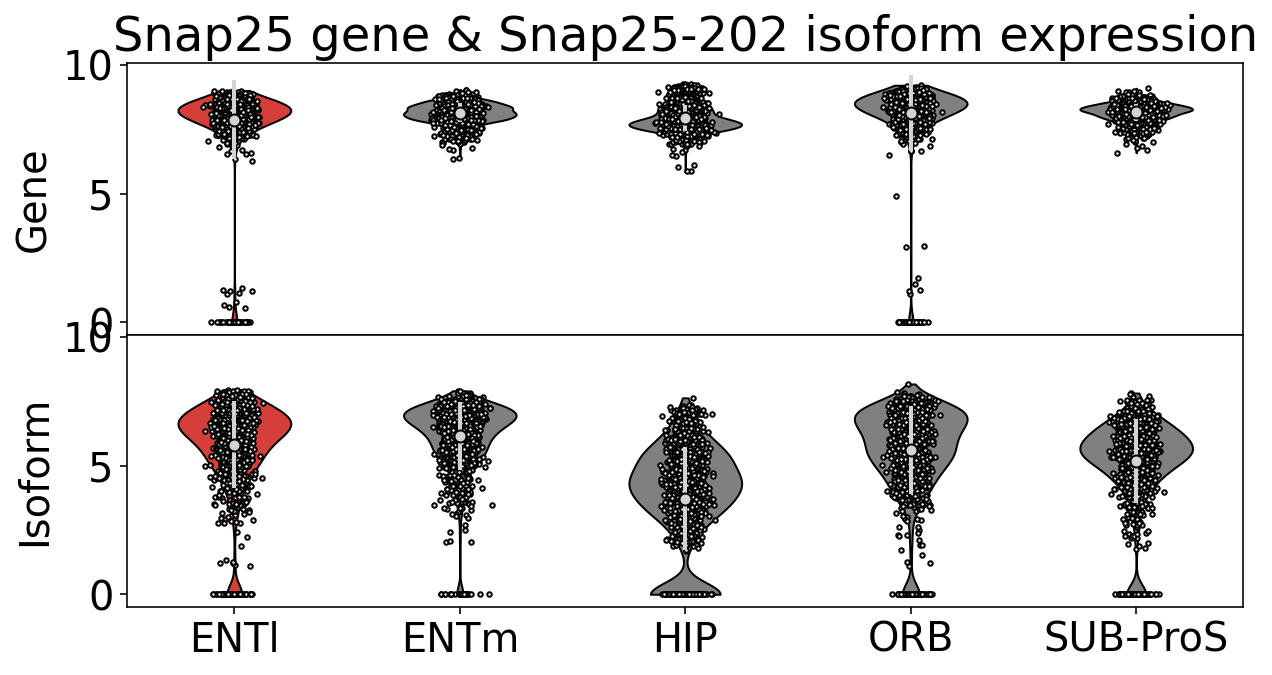

In [26]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.region_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_region)[0]#[0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.region_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.region_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene",
})


ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/region_DE_violin.png", bbox_inches='tight',dpi=300)
plt.show()

In [27]:
gene.obs

,cell_id,cluster_id,cluster_label,subclass_id,subclass_label,region_label,class_label,cluster_color,class_id,cell_counts,percent_mito,n_genes,pass_count_filter,leiden,louvain
0,SM-GE5TN_S001_E1-50,345,345_CA1,1,CA1-ProS,HIP,Glutamatergic,#680DFF,1,285.385925,2.006860,11061,True,0,0
1,SM-GE5TN_S002_E1-50,362,362_DG,6,DG,HIP,Glutamatergic,#3447B9,1,293.711304,2.291301,7850,True,11,12
2,SM-GE5TN_S003_E1-50,333,333_CA1-ProS,1,CA1-ProS,HIP,Glutamatergic,#8274BF,1,274.227692,1.416899,10041,True,0,0
3,SM-GE5TN_S004_E1-50,330,330_CA1-ProS,1,CA1-ProS,HIP,Glutamatergic,#8883C0,1,311.943085,1.970604,10730,True,0,0
4,SM-GE5TN_S005_E1-50,337,337_CA1,1,CA1-ProS,HIP,Glutamatergic,#A68CFF,1,349.485565,1.718618,9685,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603-1,SM-GE93M_S371_E1-50,72,72_Sst,36,Sst,SUB-ProS,GABAergic,#B57014,0,453.808594,2.793207,6567,True,3,5
1604-1,SM-GE93M_S372_E1-50,82,82_Sst,36,Sst,SUB-ProS,GABAergic,#AC7913,0,538.135864,1.254011,8901,True,3,5
1606-1,SM-GE93M_S374_E1-50,95,95_Sst,36,Sst,SUB-ProS,GABAergic,#DC7C16,0,536.312988,1.453869,7297,True,3,5
1607-1,SM-GE93M_S375_E1-50,49,49_Vip,38,Vip,SUB-ProS,GABAergic,#A45FBF,0,540.657471,0.907577,6451,True,6,2


In [28]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 7843 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

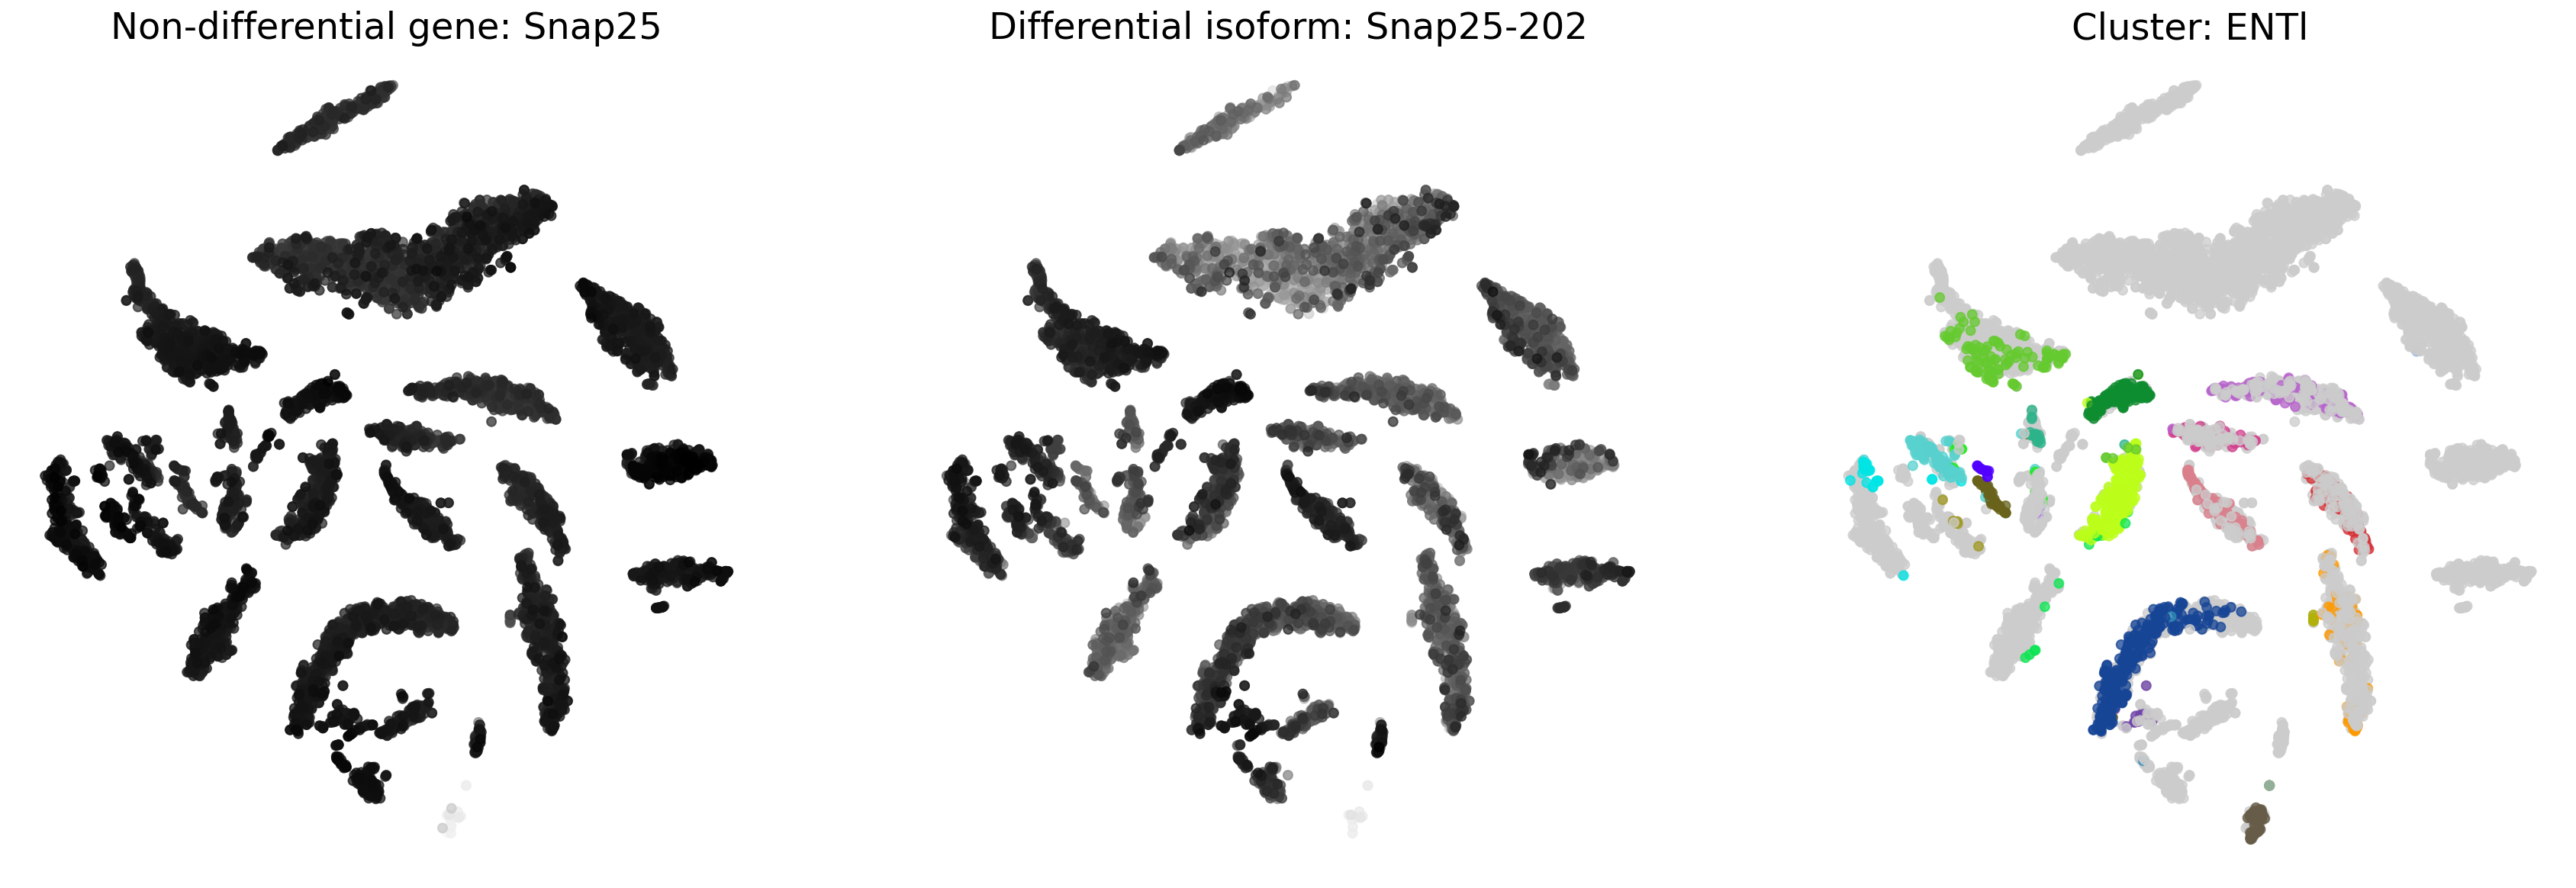

In [29]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_region
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["region_label"]!=specific_region)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_region))
plt.savefig("../../figures/class_DE_nca.png", bbox_inches='tight',dpi=300)
plt.show()

In [30]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [31]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [32]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

577 isoforms from 463 genes identified.


In [34]:
markers_isoform.to_csv("../../tables/unordered/region_GLUT_DE.csv")